# Signal correction pipeline optimization

Signal preprocessing pipeline is all set to go and installable from PyPi. Let's test it out and see how it runs. I'm mostly interested in how long it's going to take to process the whole dataset - submission notebook runtime limit is 9 hrs.

## Notebook set-up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
import pickle
import time

from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Local imports
import configuration as config

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Signal correction pipeline

In [2]:
# !pip install ariel-data-preprocessing

from ariel_data_preprocessing.signal_correction import SignalCorrection

## 2. Run time

In [3]:
planet_nums = [1,2,4]
downsampling = [True, False]

runtime_results_file = f'{config.EXPERIMENT_RESULTS_DIRECTORY}/signal_correction_runtimes-{"-".join(map(str, planet_nums))}.csv'

if Path(runtime_results_file).is_file() is False:

    results = {
        'planet_nums': [],
        'runtimes': [],
        'downsampling': []
    }

    for downsample in [True, False]:

        for planets in planet_nums:

            print(f'Signal correcting {planets} planets, downasampling {downsample}', end='\r')

            start_time = time.time()

            signal_correction = SignalCorrection(
                input_data_path=config.RAW_DATA_DIRECTORY,
                output_data_path=config.SIGNAL_CORRECTED_DIRECTORY,
                n_planets=planets,
                downsample_fgs=downsample,
            )
            
            signal_correction.run()

            results['downsampling'].append(downsample)
            results['planet_nums'].append(planets)
            results['runtimes'].append((time.time() - start_time) / 60)

    results_df = pd.DataFrame(results)
    results_df.to_csv(runtime_results_file, index=False)

else:
    results_df = pd.read_csv(runtime_results_file)

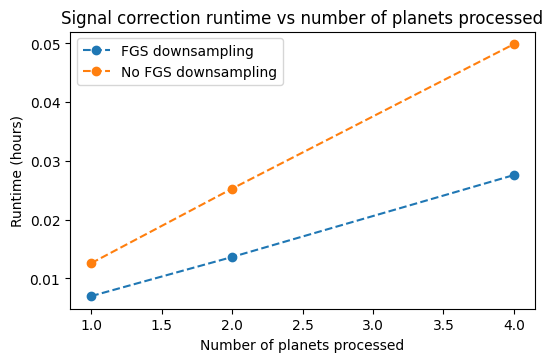

In [14]:
plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH * 0.6))
plt.title('Signal correction runtime vs number of planets processed')
plt.plot(
    results_df[results_df['downsampling'] == True]['planet_nums'],
    results_df[results_df['downsampling'] == True]['runtimes'] / 60,
    marker='o',
    linestyle='dashed',
    label='FGS downsampling'
)
plt.plot(
    results_df[results_df['downsampling'] == False]['planet_nums'],
    results_df[results_df['downsampling'] == False]['runtimes'] / 60,
    marker='o',
    linestyle='dashed',
    label='No FGS downsampling'
)
plt.xlabel('Number of planets processed')
plt.ylabel('Runtime (hours)')
plt.legend(loc='upper left')
plt.show()

In [15]:
# Linear regression to predict runtime for 1100 planets
from sklearn.linear_model import LinearRegression

# Analyze both downsampling conditions
for downsample in [True, False]:
    condition = "With" if downsample else "No"
    data = results_df[results_df['downsampling'] == downsample]
    
    # Fit linear regression
    X = data['planet_nums'].values.reshape(-1, 1)
    y = data['runtimes'].values
    model = LinearRegression().fit(X, y)
    
    # Predict for 1100 planets
    prediction_min = model.predict([[1100]])[0]
    prediction_hrs = prediction_min / 60
    
    print(f"{condition} FGS downsampling:")
    print(f"  Slope: {model.coef_[0]:.3f} min/planet")
    print(f"  R²: {model.score(X, y):.3f}")
    print(f"  1100 planets: {prediction_min:.1f} min ({prediction_hrs:.1f} hrs)")
    print(f"  Within 9hr limit: {'pass' if prediction_hrs <= 9 else 'fail'}")
    print()

With FGS downsampling:
  Slope: 0.413 min/planet
  R²: 1.000
  1100 planets: 454.5 min (7.6 hrs)
  Within 9hr limit: pass

No FGS downsampling:
  Slope: 0.745 min/planet
  R²: 1.000
  1100 planets: 819.4 min (13.7 hrs)
  Within 9hr limit: fail



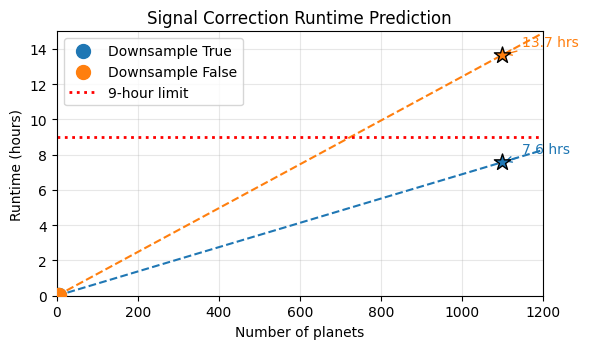

In [17]:
# Visualize linear regression predictions
plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH * 0.6))

colors = ['tab:blue', 'tab:orange']
labels = ['Downsample True', 'Downsample False']
x_pred = np.linspace(0, 1200, 100)

for i, downsample in enumerate([True, False]):
    data = results_df[results_df['downsampling'] == downsample]
    
    # Plot data points
    plt.scatter(
        data['planet_nums'],
        data['runtimes'] / 60, 
        color=colors[i],
        s=100,
        label=labels[i],
        zorder=3)
    
    # Fit and plot regression line
    X = data['planet_nums'].values.reshape(-1, 1)
    y = data['runtimes'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(x_pred.reshape(-1, 1)) / 60
    
    plt.plot(
        x_pred,
        y_pred,
        color=colors[i],
        linestyle='--'
    )
    
    # Show 1100 planet prediction
    pred_1100 = model.predict([[1100]])[0] / 60

    plt.scatter(
        [1100],
        [pred_1100],
        color=colors[i],
        s=150,
        marker='*', 
        edgecolors='black',
        zorder=4
    )

    plt.annotate(
        f'{pred_1100:.1f} hrs',
        xy=(1100, pred_1100), 
        xytext=(1100+50, pred_1100+0.5),
        color=colors[i],
        arrowprops=dict(arrowstyle='->',color=colors[i])
    )

# Add 9-hour limit line
plt.axhline(y=9, color='red', linestyle=':', linewidth=2, label='9-hour limit')

plt.title('Signal Correction Runtime Prediction')
plt.xlabel('Number of planets')
plt.ylabel('Runtime (hours)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1200)
plt.ylim(0, 15)
plt.tight_layout()
plt.show()